# MIE451/1513 Decision Support System -- Data Science Solution

## Be sure to let us know:
i. what location you chose (and remember to sign up on Piazza so there are no duplicates),

ii. what preprocessing steps you implemented


*   **Location: Brandon, Manitoba.**


*   **City code:154951**



*   **https://www.tripadvisor.ca/Hotels-g154951-Brandon_Manitoba-Hotels.html**






In [91]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
df = pd.read_csv('reviews.csv', header=None, names=['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode'])
df

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,data/ca/499159/1950755/513398757.html,Canadian Wilderness Inn,"""Myself and 2 friends stayed four nights at th...",5,positive,"August 15, 2017",306 Mountain Street,Boissevain,Manitoba,R0K 0E0
1,data/ca/499159/1950755/396888289.html,Canadian Wilderness Inn,"""We stayed here the beginning of July. After r...",5,positive,"July 25, 2016",306 Mountain Street,Boissevain,Manitoba,R0K 0E0
2,data/ca/499159/1950755/520331753.html,Canadian Wilderness Inn,"""We checked in here at 7:30 on the Tuesday and...",4,positive,"September 1, 2017",306 Mountain Street,Boissevain,Manitoba,R0K 0E0
3,data/ca/499159/1950755/601211283.html,Canadian Wilderness Inn,"""I thought I would take the time to thank Shaw...",5,positive,"July 30, 2018",306 Mountain Street,Boissevain,Manitoba,R0K 0E0
4,data/ca/499159/1950755/385104629.html,Canadian Wilderness Inn,"""When making a reservation make sure you reque...",3,negative,"June 22, 2016",306 Mountain Street,Boissevain,Manitoba,R0K 0E0
...,...,...,...,...,...,...,...,...,...,...
1900,data/ca/1809242/15458337/749315811.html,The Souris Hotel,"""This was my 1st stay and was highly impressed...",5,positive,"March 5, 2020",105 1st Street South B310,Souris,Manitoba,R0K 2C0
1901,data/ca/1809242/15458337/751542690.html,The Souris Hotel,"""Nice and clean hotel. staff very friendly an...",5,positive,"March 21, 2020",105 1st Street South B310,Souris,Manitoba,R0K 2C0
1902,data/ca/1809242/15458337/708290808.html,The Souris Hotel,"""We stayed only one night as we were passing t...",5,positive,"September 9, 2019",105 1st Street South B310,Souris,Manitoba,R0K 2C0
1903,data/ca/1809242/15458337/749220873.html,The Souris Hotel,"""Great hotel in a great little town. Hotel wa...",5,positive,"March 5, 2020",105 1st Street South B310,Souris,Manitoba,R0K 2C0


In [93]:
df.City.unique()

array(['Boissevain', 'Rivers', 'Minnedosa', 'Brandon', 'Virden', 'Souris'],
      dtype=object)

**Since trip-advisor-crawler.py downloaded not only city Brandon, but also other nearby cities. I need to filter out other city.**

In [94]:
df = df[df.City == 'Brandon']
len(df.hotelName.unique())

18

In [95]:
for i in df.hotelName.unique():
    print('num of reviews in hotel '+str(i)+' is '+str(df[df.hotelName==i].shape[0]))

num of reviews in hotel Colonial Inn is 34
num of reviews in hotel Travelodge by Wyndham Brandon is 30
num of reviews in hotel Motel 6 Brandon MB is 100
num of reviews in hotel Comfort Inn Brandon is 95
num of reviews in hotel Days Inn &amp; Suites by Wyndham Brandon is 307
num of reviews in hotel Cottonwood Acres B &amp; B is 5
num of reviews in hotel Braeview Bed and Breakfast is 5
num of reviews in hotel Best Western Plus Brandon Inn is 254
num of reviews in hotel Clarion Hotel &amp; Suites is 110
num of reviews in hotel Keystone Motor Inn is 7
num of reviews in hotel Redwood Motor Inn is 25
num of reviews in hotel Super 8 by Wyndham Brandon MB is 357
num of reviews in hotel 12th St. Studio/Gallery/B&amp;B is 2
num of reviews in hotel Lakeview Inns &amp; Suites - Brandon is 239
num of reviews in hotel Mid-Way Motel is 20
num of reviews in hotel Empire Inn is 10
num of reviews in hotel Victoria Inn Hotel &amp; Convention Centre is 125
num of reviews in hotel Canad Inns Brandon is 94


**Although I have 18 hotels data, but some of hotel have only a few reviews, which is not convincible. So I will filter out some hotel with small number of reviews and keep number of hotels in the range of 10-20. Threshold is 20, I will filter out hotels with number of reviews less than 20. After that, number of hotels become 13.**

In [96]:
list_hotel = [i for i in df.hotelName.unique() if df[df.hotelName==i].shape[0] >= 20]

In [97]:
df = df[df.hotelName.isin(list_hotel)]

In [98]:
len(df.hotelName.unique())

13

**Number of hotel in Brandon is 13, which is in range of 10-20.**

# Q1

**(a).**

In [99]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()


In [100]:
reviews = df['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
reviewDF

100%|██████████| 1790/1790 [00:01<00:00, 1032.36it/s]


,reviewCol,vader
0,"""This is a disgusting place. please do not le...",-0.7522
1,"""The place is comfortable, affordable, a littl...",0.9483
2,"""Colonial Inn: Not to be recommended. Extremel...",-0.8137
3,"""Actually 4 1\u002F2 stars. We have stayed he...",0.9914
4,"""We stayed here for the Manitoba for the Winte...",0.7026
...,...,...
1785,"""Met for Christmas supper with a group of frie...",0.9565
1786,"""I must say after staying in many hotels aroun...",0.9080
1787,"""To put things in perspective, the night befor...",0.7906
1788,"""Spent 2 nights last week in the Canad Inns.\n...",0.9845


In [101]:
df = df.merge(reviewDF, how='left', left_on='reviewColumn', right_on='reviewCol')
df

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode,reviewCol,vader
0,data/ca/154951/182638/283191987.html,Colonial Inn,"""This is a disgusting place. please do not le...",1,negative,"June 26, 2015",1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"""This is a disgusting place. please do not le...",-0.7522
1,data/ca/154951/182638/726695876.html,Colonial Inn,"""The place is comfortable, affordable, a littl...",4,positive,"November 15, 2019",1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"""The place is comfortable, affordable, a littl...",0.9483
2,data/ca/154951/182638/629599466.html,Colonial Inn,"""Colonial Inn: Not to be recommended. Extremel...",2,negative,"October 30, 2018",1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"""Colonial Inn: Not to be recommended. Extremel...",-0.8137
3,data/ca/154951/182638/751498101.html,Colonial Inn,"""Actually 4 1\u002F2 stars. We have stayed he...",4,positive,"March 20, 2020",1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"""Actually 4 1\u002F2 stars. We have stayed he...",0.9914
4,data/ca/154951/182638/472242548.html,Colonial Inn,"""We stayed here for the Manitoba for the Winte...",2,negative,"April 2, 2017",1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"""We stayed here for the Manitoba for the Winte...",0.7026
...,...,...,...,...,...,...,...,...,...,...,...,...
1785,data/ca/154951/551021/445424181.html,Canad Inns Brandon,"""Met for Christmas supper with a group of frie...",4,positive,"December 19, 2016",1125 18th St Keystone Centre,Brandon,Manitoba,R7A 7C5,"""Met for Christmas supper with a group of frie...",0.9565
1786,data/ca/154951/551021/4949999.html,Canad Inns Brandon,"""I must say after staying in many hotels aroun...",1,negative,"April 6, 2006",1125 18th St Keystone Centre,Brandon,Manitoba,R7A 7C5,"""I must say after staying in many hotels aroun...",0.9080
1787,data/ca/154951/551021/616088893.html,Canad Inns Brandon,"""To put things in perspective, the night befor...",3,negative,"September 12, 2018",1125 18th St Keystone Centre,Brandon,Manitoba,R7A 7C5,"""To put things in perspective, the night befor...",0.7906
1788,data/ca/154951/551021/573576919.html,Canad Inns Brandon,"""Spent 2 nights last week in the Canad Inns.\n...",4,positive,"April 15, 2018",1125 18th St Keystone Centre,Brandon,Manitoba,R7A 7C5,"""Spent 2 nights last week in the Canad Inns.\n...",0.9845


In [102]:
df_rating_vader = df.groupby(['hotelName'])['ratingScore', 'vader'].mean()
df_rating_vader.columns = ['average_ground_truth_rating', 'average_Vader_sentiment']
df_rating_vader

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Best Western Plus Brandon Inn,4.259843,0.795885
Canad Inns Brandon,3.382979,0.640087
Clarion Hotel &amp; Suites,3.500000,0.591727
Colonial Inn,2.617647,0.450179
Comfort Inn Brandon,3.800000,0.754842
Days Inn &amp; Suites by Wyndham Brandon,4.254072,0.666563
Lakeview Inns &amp; Suites - Brandon,4.129707,0.723138
Mid-Way Motel,3.400000,0.808930
Motel 6 Brandon MB,4.150000,0.763756


**(b).**

In [103]:
df_rating_sort = df_rating_vader.sort_values(by=['average_ground_truth_rating'], ascending=False)
df_rating_sort.head()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Super 8 by Wyndham Brandon MB,4.324930,0.762683
Best Western Plus Brandon Inn,4.259843,0.795885
Days Inn &amp; Suites by Wyndham Brandon,4.254072,0.666563
Motel 6 Brandon MB,4.150000,0.763756
Lakeview Inns &amp; Suites - Brandon,4.129707,0.723138


In [104]:
df_rating_sort.tail()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Mid-Way Motel,3.400000,0.808930
Canad Inns Brandon,3.382979,0.640087
Travelodge by Wyndham Brandon,3.100000,0.531937
Redwood Motor Inn,2.680000,0.185456
Colonial Inn,2.617647,0.450179


In [105]:
df_vader_sort = df_rating_vader.sort_values(by=['average_Vader_sentiment'], ascending=False)
df_vader_sort.head()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Mid-Way Motel,3.400000,0.808930
Best Western Plus Brandon Inn,4.259843,0.795885
Motel 6 Brandon MB,4.150000,0.763756
Super 8 by Wyndham Brandon MB,4.324930,0.762683
Victoria Inn Hotel &amp; Convention Centre,3.944000,0.757114


In [106]:
df_vader_sort.tail()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Canad Inns Brandon,3.382979,0.640087
Clarion Hotel &amp; Suites,3.500000,0.591727
Travelodge by Wyndham Brandon,3.100000,0.531937
Colonial Inn,2.617647,0.450179
Redwood Motor Inn,2.680000,0.185456




*   **Top 5 ground truth rating: Super 8 by Wyndham Brandon MB, Best Western Plus Brandon Inn, Days Inn &amp; Suites by Wyndham Brandon, Motel 6 Brandon MB, and Lakeview Inns &amp; Suites - Brandon.**
*   **Bottom 5 ground truth rating: Mid-Way Motel, Canad Inns Brandon, Travelodge by Wyndham Brandon, Redwood Motor Inn, and Colonial Inn.**


*   **Top 5 vader rating: Mid-Way Motel, Best Western Plus Brandon Inn, Motel 6 Brandon MB, Super 8 by Wyndham Brandon MB, and Victoria Inn Hotel &amp; Convention Centre.**
*   **Bottom 5 vader rating: Canad Inns Brandon, Clarion Hotel &amp; Suites, Travelodge by Wyndham Brandon, Colonial Inn, and Redwood Motor Inn.**


*   **For top rating hotels: The ranking of hotels does not match in top 5 ground truth rating and top 5 vader rating. But Super 8 by Wyndham Brandon MB, Best Western Plus Brandon Inn, and Motel 6 Brandon MB exist in both of top 5 ground truth rating and top 5 vader rating. Thus, 3/5 hotels match.**
*   **For bottom rating hotels: Only ranking of Travelodge by Wyndham Brandon	match in bottom 5 ground truth rating and bottom 5 vader rating.But Canad Inns Brandon, Travelodge by Wyndham Brandon, Colonial Inn, and Redwood Motor Inn exist in both of bottom 5 ground truth rating and bottom 5 vader rating. Thus, 4/5 hotels match.**






# Q2

**(a).**

In [107]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('brandon')   # location specific
    return stop

def getTopKWords(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk


In [108]:
df_pos = df[df.groundTruth == 'positive']
topk_pos = getTopKWords(df_pos, 500)
pos_word = [item[0] for item in topk_pos[:50]]
topk_pos[:50]

[('clean', 884),
 ('breakfast', 861),
 ('great', 689),
 ('good', 659),
 ('nice', 561),
 ('comfortable', 471),
 ('would', 447),
 ('friendly', 446),
 ('pool', 441),
 ('stayed', 437),
 ('one', 301),
 ('well', 287),
 ('place', 269),
 ('beds', 265),
 ('hot', 260),
 ('desk', 255),
 ('night', 249),
 ('area', 237),
 ('front', 230),
 ('bed', 229),
 ('time', 227),
 ('quiet', 223),
 ('helpful', 215),
 ('super', 190),
 ('excellent', 181),
 ('really', 176),
 ('location', 174),
 ('nthe', 174),
 ('inn', 174),
 ('recommend', 174),
 ('also', 170),
 ('get', 165),
 ('like', 164),
 ('service', 162),
 ('best', 162),
 ('definitely', 158),
 ('coffee', 155),
 ('check', 148),
 ('price', 143),
 ('highway', 142),
 ('free', 141),
 ('tub', 140),
 ('always', 139),
 ('restaurant', 135),
 ('could', 133),
 ('new', 132),
 ('back', 131),
 ('food', 131),
 ('family', 129),
 ('next', 127)]

In [109]:
df_neg = df[df.groundTruth == 'negative']
topk_neg = getTopKWords(df_neg, 500)
neg_word = [item[0] for item in topk_neg[:50]]
topk_neg[:50]

[('breakfast', 230),
 ('would', 229),
 ('clean', 194),
 ('good', 182),
 ('one', 180),
 ('desk', 180),
 ('night', 176),
 ('pool', 170),
 ('nice', 168),
 ('front', 168),
 ('could', 137),
 ('stayed', 133),
 ('time', 122),
 ('get', 118),
 ('bed', 117),
 ('like', 110),
 ('check', 110),
 ('place', 108),
 ('back', 107),
 ('hot', 106),
 ('nthe', 102),
 ('service', 98),
 ('area', 94),
 ('next', 90),
 ('great', 90),
 ('well', 88),
 ('told', 87),
 ('kids', 87),
 ('even', 84),
 ('friendly', 83),
 ('floor', 81),
 ('said', 80),
 ('also', 79),
 ('beds', 77),
 ('asked', 77),
 ('price', 75),
 ('really', 73),
 ('comfortable', 72),
 ('people', 72),
 ('booked', 71),
 ('door', 70),
 ('went', 70),
 ('bathroom', 69),
 ('morning', 69),
 ('two', 67),
 ('tub', 65),
 ('day', 64),
 ('inn', 63),
 ('hotels', 63),
 ('never', 62)]

**words appear in both positive and negative reviews.**

In [110]:
[item1 for item1 in pos_word for item2 in neg_word if item1 == item2]

['clean',
 'breakfast',
 'great',
 'good',
 'nice',
 'comfortable',
 'would',
 'friendly',
 'pool',
 'stayed',
 'one',
 'well',
 'place',
 'beds',
 'hot',
 'desk',
 'night',
 'area',
 'front',
 'bed',
 'time',
 'really',
 'nthe',
 'inn',
 'also',
 'get',
 'like',
 'service',
 'check',
 'price',
 'tub',
 'could',
 'back',
 'next']

*  **location specific: 'bed', 'inn', 'desk', 'bathroom' ,'hotel', and 'resuaurant'.**
*  **['clean',
 'breakfast',
 'great',
 'good',
 'nice',
 'comfortable',
 'would',
 'friendly',
 'pool',
 'stayed',
 'one',
 'well',
 'place',
 'beds',
 'hot',
 'desk',
 'night',
 'area',
 'front',
 'bed',
 'time',
 'really',
 'nthe',
 'inn',
 'also',
 'get',
 'like',
 'service',
 'check',
 'price',
 'tub',
 'could',
 'back',
 'next'] appear in both positive and negative reviews.**
*  **It is really surprised me that 'great',
 'good',
 'nice',
 'comfortable', 'friendly', 'well', and 'like' apppear in both list, since these words are positive words, it is strange to appear in negative list.**

**(b).**

In [111]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
tagger = PerceptronTagger()
pos_tag = tagger.tag


# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [112]:
# to make the results more useable, we clean up the tree results shown above. 
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

def getTopKNP(df, kNPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(kNPs)
    return topk

In [113]:
pos_np = getTopKNP(df[df.groundTruth=='positive'], 50)
pos_np_list = [item[0] for item in pos_np]
pos_np

[('front desk', 107),
 ('hot tub', 81),
 ('continent breakfast', 63),
 ('day inn', 53),
 ('pool area', 46),
 ('great place', 35),
 ('comfort bed', 32),
 ('tran canada highway', 25),
 ('first time', 25),
 ('next time', 24),
 ('victoria inn', 23),
 ('comfort inn', 21),
 ('water slide', 20),
 ('hot breakfast', 19),
 ('good breakfast', 19),
 ('nice place', 18),
 ('good valu', 18),
 ('park lot', 17),
 ('great locat', 17),
 ('free breakfast', 17),
 ('easi access', 15),
 ('complimentari breakfast', 15),
 ('best western', 14),
 ('coffe maker', 13),
 ('good size', 13),
 ('tran canada', 13),
 ('breakfast area', 13),
 ('lakeview inn', 13),
 ('good place', 12),
 ('long day', 12),
 ('mini fridg', 12),
 ('excel servic', 12),
 ('clean bed', 12),
 ('canad inn', 12),
 ('great breakfast', 11),
 ('nice clean', 11),
 ('sever time', 10),
 ('second floor', 10),
 ('road trip', 10),
 ('south end', 10),
 ('first floor', 10),
 ('ga station', 10),
 ('nthe breakfast', 10),
 ('nice touch', 10),
 ('next door', 10),

In [114]:
neg_np = getTopKNP(df[df.groundTruth=='negative'], 50)
neg_np_list = [item[0] for item in neg_np]
neg_np

[('front desk', 89),
 ('hot tub', 27),
 ('free breakfast', 17),
 ('pool area', 14),
 ('park lot', 13),
 ('continent breakfast', 12),
 ('victoria inn', 12),
 ('next time', 11),
 ('breakfast area', 11),
 ('next morn', 11),
 ('canad inn', 11),
 ('hot water', 10),
 ('main floor', 10),
 ('air condition', 8),
 ('second floor', 8),
 ('hot item', 8),
 ('day inn', 8),
 ('water slide', 7),
 ('next day', 7),
 ('royal oak', 7),
 ('bed bug', 6),
 ('non smoke', 6),
 ('credit card', 6),
 ('custom servic', 6),
 ('long day', 6),
 ('ground floor', 6),
 ('first night', 6),
 ('best western', 6),
 ('comfort inn', 6),
 ('hockey team', 6),
 ('pool attend', 6),
 ('coloni inn', 5),
 ('keyston centr', 5),
 ('queen bed', 5),
 ('nice place', 5),
 ('front desk clerk', 5),
 ('next night', 5),
 ('hot breakfast', 5),
 ('hotel com', 5),
 ('hockey tournament', 5),
 ('pool side', 5),
 ('winter fair', 4),
 ('long time', 4),
 ('tran canada highway', 4),
 ('air condit', 4),
 ('big deal', 4),
 ('first time', 4),
 ('boston p

**noun phrases appear in both positive and negative reviews**

In [115]:
[item1 for item1 in pos_np_list for item2 in neg_np_list if item1 == item2]

['front desk',
 'hot tub',
 'continent breakfast',
 'day inn',
 'pool area',
 'tran canada highway',
 'first time',
 'next time',
 'victoria inn',
 'comfort inn',
 'water slide',
 'hot breakfast',
 'nice place',
 'park lot',
 'free breakfast',
 'best western',
 'breakfast area',
 'long day',
 'canad inn',
 'second floor',
 'front desk clerk']



*   **['front desk',
 'hot tub',
 'continent breakfast',
 'day inn',
 'pool area',
 'tran canada highway',
 'first time',
 'next time',
 'victoria inn',
 'comfort inn',
 'water slide',
 'hot breakfast',
 'nice place',
 'park lot',
 'free breakfast',
 'best western',
 'breakfast area',
 'long day',
 'canad inn',
 'second floor',
 'front desk clerk'] appear in both positive and negative reviews. I did not expect 'pool area' appear in positive reviews. Maybe there is a negation before 'poor area' like 'not a poor area'. So it is actually say it is a nice area but it contain noun phrase 'poor area'.**



**(c).**

In [116]:
grammar_c = r"""
    NBAR:
        {<DT>?<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>*<IN|VBD>*<NBAR>}  # Above, connected with in/of/etc...
        {<NBAR>}
"""

# Create phrase tree
chunker = nltk.RegexpParser(grammar_c)

In [117]:
new_pos_np = getTopKNP(df[df.groundTruth=='positive'], 50)
new_pos_np_list = [item[0] for item in new_pos_np]
new_pos_np

[('front desk', 63),
 ('hot tub', 58),
 ('continent breakfast', 43),
 ('day inn', 38),
 ('great place', 33),
 ('pool area', 30),
 ('comfort bed', 26),
 ('next time', 23),
 ('first time', 23),
 ('tran canada highway', 21),
 ('nice place', 16),
 ('hot breakfast', 15),
 ('victoria inn', 15),
 ('comfort inn', 14),
 ('great locat', 13),
 ('easi access', 12),
 ('good breakfast', 12),
 ('water slide', 12),
 ('tran canada', 11),
 ('good valu', 11),
 ('best western', 11),
 ('mini fridg', 10),
 ('clean bed', 10),
 ('reason price', 9),
 ('coffe maker', 9),
 ('good size', 9),
 ('good place', 9),
 ('long day', 9),
 ('nthe breakfast', 9),
 ('complimentari breakfast', 9),
 ('free breakfast', 9),
 ('excel servic', 9),
 ('lakeview inn', 9),
 ('sever time', 8),
 ('long drive', 8),
 ('first floor', 8),
 ('queen bed', 8),
 ('nice touch', 8),
 ('everi time', 8),
 ('across canada', 8),
 ('second floor', 7),
 ('great time', 7),
 ('park lot', 7),
 ('ga station', 7),
 ('front desk clerk', 7),
 ('waffl maker', 

**similarity&difference: Note at least 3 observations on the similarities or differences between these noun phrases and those in Q2(b).**

In [118]:
len([item1 for item1 in pos_np_list for item2 in new_pos_np_list if item1 == item2])

41

In [119]:
new_neg_np = getTopKNP(df[df.groundTruth=='negative'], 50)
new_neg_np_list = [item[0] for item in new_neg_np]
new_neg_np

[('front desk', 51),
 ('hot tub', 18),
 ('free breakfast', 15),
 ('next time', 10),
 ('park lot', 8),
 ('canad inn', 8),
 ('hot water', 7),
 ('air condition', 7),
 ('call front desk', 7),
 ('main floor', 7),
 ('breakfast area', 7),
 ('continent breakfast', 7),
 ('second floor', 7),
 ('per night', 7),
 ('pool area', 6),
 ('custom servic', 6),
 ('water slide', 6),
 ('best western', 6),
 ('day inn', 6),
 ('next morn', 6),
 ('victoria inn', 6),
 ('bed bug', 5),
 ('credit card', 5),
 ('queen bed', 5),
 ('nice place', 5),
 ('hockey tournament', 5),
 ('pool side', 5),
 ('coloni inn', 4),
 ('winter fair', 4),
 ('keyston centr', 4),
 ('non smoke', 4),
 ('good time', 4),
 ('tran canada highway', 4),
 ('air condit', 4),
 ('big deal', 4),
 ('boston pizza', 4),
 ('comfort inn', 4),
 ('hot item', 4),
 ('hockey team', 4),
 ('mani hotel', 4),
 ('upon arriv', 4),
 ('fire alarm', 4),
 ('wi fi', 4),
 ('first night', 4),
 ('second night', 4),
 ('extra blanket', 4),
 ('last time', 4),
 ('pool attend', 4),


**similarity&difference: Note at least 3 observations on the similarities or differences between these noun phrases and those in Q2(b).**

In [120]:
len([item1 for item1 in neg_np_list for item2 in new_neg_np_list if item1 == item2])

38

**Comparing overlap of noun phrase between positive and negative reviews to determine which pattern is more effective.**

In [121]:
len([item1 for item1 in pos_np_list for item2 in neg_np_list if item1 == item2])

21

In [122]:
len([item1 for item1 in new_pos_np_list for item2 in new_neg_np_list if item1 == item2])

16


*   **I think my own designed grammar pattern is more effective for sentiment analysis since the number of overlapping between positive and negative noun phrase is only 16. That is less than that of pattern in Q2(b) with 21. Number of overlapping between positive and negative noun phrase is small means positive and negative sentiment are more distinguishable.**


# Q3

**(a)**

In [123]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [124]:
reviews = df['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
topk = getTopKWords(reviewDF, 500)
finaldf = dataFrameTransformation(df, reviewDF, topk)
finaldf.head()

100%|██████████| 1790/1790 [00:01<00:00, 1026.45it/s]


,hotelName,ratingScore,groundTruth,reviewCol,vader,breakfast,clean,good,great,nice,would,pool,stayed,comfortable,friendly,one,desk,night,front,place,well,hot,time,bed,beds,area,get,nthe,like,could,service,check,really,also,quiet,helpful,back,inn,location,super,...,couch,parents,might,behind,tea,head,upon,flat,swimming,young,priced,building,polite,ready,professional,whole,light,visiting,suites,plenty,royal,oak,space,walked,spent,expensive,downtown,hour,floors,machine,slept,name,pleasantly,older,checking,nbreakfast,decor,dogs,job,per
0,Colonial Inn,1,negative,"""This is a disgusting place. please do not le...",-0.7522,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Colonial Inn,4,positive,"""The place is comfortable, affordable, a littl...",0.9483,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Colonial Inn,2,negative,"""Colonial Inn: Not to be recommended. Extremel...",-0.8137,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Colonial Inn,4,positive,"""Actually 4 1\u002F2 stars. We have stayed he...",0.9914,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Colonial Inn,2,negative,"""We stayed here for the Manitoba for the Winte...",0.7026,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [125]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf[label_column], finaldf[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf
miScoredf = getMI(topk, finaldf)
miScoredf.head()

,Word,MI Score
98,told,0.030239
3,great,0.022569
91,said,0.017147
96,asked,0.016923
45,excellent,0.015344


**'told', 'great', 'said', 'asked', and 'excellent' get the highest MI values. I think it make sense that 'great' and 'excellent' get the highest MI values since they indicate positive sentiment. While 'told', 'said', and 'asked' are all verbs, they did not really make sense that get the highest MI.**

**(b).**

In [126]:
def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [127]:
# grammar_np = r"""
#     NBAR:
#         {<DT>?<JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
#     NP:
#         {<NBAR>*<IN|VBD>*<NBAR>+}  # Above, connected with in/of/etc...
# """
grammar_np = r"""
    NBAR:
        {<DT>?<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>*<IN|VBD>*<NBAR>}  # Above, connected with in/of/etc...
        {<NBAR>}
"""
# Create phrase tree
chunker = nltk.RegexpParser(grammar_np)
reviews = df['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
topk_np = getTopKNP(reviewDF, 500)
finaldf_np = NPdataFrameTransformation(df, reviewDF, topk_np)
finaldf_np.head()


100%|██████████| 1790/1790 [00:01<00:00, 1032.00it/s]


,hotelName,ratingScore,groundTruth,reviewCol,vader,front desk,hot tub,continent breakfast,day inn,pool area,great place,next time,comfort bed,first time,tran canada highway,free breakfast,nice place,victoria inn,water slide,comfort inn,hot breakfast,best western,park lot,canad inn,second floor,good breakfast,great locat,queen bed,main floor,good valu,breakfast area,easi access,clean bed,long day,nthe breakfast,good size,good place,tran canada,next morn,complimentari breakfast,...,truck stop,found properti,good valu overnight,near airport,great way,hot soup,breakfast clean,want suit,fantast servic,sleepless night,luggag rack,na other,local restaur,decent place,hot food,excel facil,poor custom servic,favourit place,excel bed,handi locat,lot work,eat area,hot dish,quiet locat,corpor rate,internet connect,park spot,swift current,previou visit,new home,differ hotel,breakfast day,enjoy hot tub,ask late checkout,third floor,diesel truck,real cream,stay weekend,chees omelet,real treat
0,Colonial Inn,1,negative,"""This is a disgusting place. please do not le...",-0.7522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Colonial Inn,4,positive,"""The place is comfortable, affordable, a littl...",0.9483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Colonial Inn,2,negative,"""Colonial Inn: Not to be recommended. Extremel...",-0.8137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Colonial Inn,4,positive,"""Actually 4 1\u002F2 stars. We have stayed he...",0.9914,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Colonial Inn,2,negative,"""We stayed here for the Manitoba for the Winte...",0.7026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(finaldf_np[label_column], finaldf_np[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Noun phrase','MI Score']
    return miScoredf
miScoredf_np = getMI(topk_np, finaldf_np)
miScoredf_np.head()

,Noun phrase,MI Score
0,front desk,0.004464
10,free breakfast,0.003896
47,call front desk,0.003183
44,hot water,0.003183
35,air condition,0.002588


**"front desk" get the highest MI values. "front desk", "free breakfast", "call front desk", "hot water", and "air condition" got the top 5 high MI Scores, which means these 5 noun phrases are highly related to sentiment. Thus, I would recommend hotels in brandon to improve front desk service and provide call service. Besides that, it is also importment to provide free breakfast, hot water and make sure that air condition is working. Because all of these can highly influence costomers' sentiments.**

# Q4

**(a).**

In [129]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    
    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)
    
    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):
    
    N = df.shape[0]
    
    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [130]:
pmiposdf = pmiForAllCal(finaldf,topk,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)

100%|██████████| 500/500 [00:01<00:00, 452.30it/s]


,pmi
pleasantly,0.243524
highly,0.239886
perfect,0.239886
excellent,0.237071
enjoyed,0.219873
...,...
dirty,-0.948774
told,-1.14149
rude,-1.22419
poor,-1.45471


In [131]:
pmiposdf.sort_values('pmi',ascending=0).head(60)

,pmi
pleasantly,0.243524
highly,0.239886
perfect,0.239886
excellent,0.237071
enjoyed,0.219873
surprised,0.215353
usual,0.2132
beautiful,0.2132
wonderful,0.209687
selection,0.205783


In [132]:
#Sorted top pmi words for negative reviews
pminegdf = pmiForAllCal(finaldf,topk,'negative')
pminegdf.sort_values('pmi',ascending=0)

100%|██████████| 500/500 [00:01<00:00, 477.23it/s]


,pmi
broken,1.2497
poor,1.21588
rude,1.15872
told,1.13378
dirty,1.06376
...,...
enjoyed,-1.43293
excellent,-1.76205
highly,-1.82864
perfect,-1.82864


In [133]:
pminegdf.sort_values('pmi',ascending=0).head(50)

,pmi
broken,1.2497
poor,1.21588
rude,1.15872
told,1.13378
dirty,1.06376
loud,1.04713
wall,1.02057
someone,1.018
give,1.00457
least,0.992303




*   **'pleasantly', 'highly', 'perfect', 'excellent', and 'enjoyed' got the highest PMI values in positive reviews, which is reasonable. All of these words are have highly positive sentiment. And also all of these words got the lowest PMI values in negative reviews.**
*   **'broken', 'poor', 'rude', 'told', and 'dirty' got the highest PMI values for negative reviews. While all the these words got the lowest PMI values in positive reviews.**
*   **Location specific findings: 'downtown', 'lakeview' got top 50 highest PMI for positive reviews. 'downtown' and 'lakeview' means the nice location and they are resonable to have high PMI with positive reviews. 'toilet' got top 50 highest PMI for negative reviews. Maybe toilet is dirty for negative reviews.**



**(b).**

In [134]:
pmiposdf_phrase = pmiForAllCal(finaldf_np,topk_np,'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:01<00:00, 485.83it/s]


,pmi
real treat,0.279891
day lobbi,0.279891
young ladi name,0.279891
across countri,0.279891
breakfast sandwich,0.279891
king size bed,0.279891
perfect place,0.279891
good motel,0.279891
small pool,0.279891
good access,0.279891


In [135]:
pminegdf_phrase = pmiForAllCal(finaldf_np,topk_np,'negative')
pminegdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 500.61it/s]


,pmi
bathroom door,1.41004
fantast servic,1.41004
dog bark,1.41004
mani place,1.41004
anoth citi,1.41004
sunday morn,1.41004
doubl bed,1.41004
call week,1.41004
good custom servic,1.41004
adjoin door,1.41004




*   **For positive reviews: Many noun phrases with high PMI are saying: 'real treat', 'king size bed', 'perfect place', 'good motel', 'good access' and so on, which is reasonable.**
*   **For negative reviews: Many noun phrases with high PMI are saying: 'dog bark', 'dirti bath', dirti sheet', 'damag wall' and so on, which is also reasonable.**
*   **But 'fantastic service' also appears as high PMI value for negative reviews, which really surprised me.**



**(c).**

In [136]:
df_rating_sort.head()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Super 8 by Wyndham Brandon MB,4.324930,0.762683
Best Western Plus Brandon Inn,4.259843,0.795885
Days Inn &amp; Suites by Wyndham Brandon,4.254072,0.666563
Motel 6 Brandon MB,4.150000,0.763756
Lakeview Inns &amp; Suites - Brandon,4.129707,0.723138


In [137]:
def NPdataFrameTransformation_q4(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].reset_index(drop=True).join(finalreviewDf)
    return finaldf

In [138]:
df_top1 = df[df.hotelName == 'Super 8 by Wyndham Brandon MB']
chunker = nltk.RegexpParser(grammar_np)
reviews_top1 = df_top1['reviewColumn'].values
reviewDF_top1 = evalSentences(reviews_top1, to_df=True, columns=['reviewCol','vader'])
topk_np_top1 = getTopKNP(reviewDF_top1, 500)
finaldf_np_top1 = NPdataFrameTransformation_q4(df_top1, reviewDF_top1, topk_np_top1)
pmiposdf_phrase = pmiForAllCal(finaldf_np_top1,topk_np_top1,'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 739.72it/s]


,pmi
great np,0.157424
peopl access,0.157424
invit clean friendli great breakfast,0.157424
first impress,0.157424
stay night,0.157424
mission trip,0.157424
drunk parti group,0.157424
heard group,0.157424
parti main floor,0.157424
problem guest,0.157424


In [139]:
pmiposdf_phrase = pmiForAllCal(finaldf_np_top1,topk_np_top1,'negative')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 500/500 [00:00<00:00, 731.32it/s]


,pmi
dvd player,1.92649
ask rep,1.92649
locat close,1.92649
walmart montana etc,1.92649
expect discount,1.92649
arriv check,1.92649
pet friendli area,1.92649
doubl bed,1.92649
explan thing,1.92649
exhaust desk,1.92649


In [140]:
df_rating_sort.tail()

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Mid-Way Motel,3.400000,0.808930
Canad Inns Brandon,3.382979,0.640087
Travelodge by Wyndham Brandon,3.100000,0.531937
Redwood Motor Inn,2.680000,0.185456
Colonial Inn,2.617647,0.450179


In [141]:
df_bottom1 = df[df.hotelName == 'Colonial Inn']
chunker = nltk.RegexpParser(grammar_np)
reviews_bottom1 = df_bottom1['reviewColumn'].values
reviewDF_bottom1 = evalSentences(reviews_bottom1, to_df=True, columns=['reviewCol','vader'])
topk_np_bottom1 = getTopKNP(reviewDF_bottom1, 500)
finaldf_np_bottom1 = NPdataFrameTransformation_q4(df_bottom1, reviewDF_bottom1, topk_np_bottom1)
pmiposdf_phrase = pmiForAllCal(finaldf_np_bottom1,topk_np_bottom1,'positive')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 333/333 [00:00<00:00, 807.95it/s]


,pmi
nthe verdict,1.22378
awesom review,1.22378
packag sugar,1.22378
extra coffe tea,1.22378
though south end,1.22378
pool area,1.22378
litter old restaur suppli,1.22378
equip side,1.22378
main recommend clean,1.22378
old restaur equip south end,1.22378


In [142]:
pmiposdf_phrase = pmiForAllCal(finaldf_np_bottom1,topk_np_bottom1,'negative')
pmiposdf_phrase.sort_values('pmi',ascending=0).head(50)

100%|██████████| 333/333 [00:00<00:00, 783.95it/s]


,pmi
coloni inn,0.348307
dirti dust,0.348307
queen bed,0.348307
shop mall restaur,0.348307
next day great,0.348307
arriv clean,0.348307
okay free breakfast,0.348307
town awesom,0.348307
great locat centr,0.348307
small extra amount,0.348307


*  **For top 1 ranked Super 8 by Wyndham Brandon MB: Positive reviews has highest PMI with noun phrase with 'great place good breakfast', 'new furniture', and so on. Negative reviews has highest PMI with noun phrase with 'expect discount', 'bed bug' and so on. Thus, we can say Super 8 by Wyndham Brandon MB is good for its good place, good breatfast, new furniture and so on. Super 8 by Wyndham Brandon MB is bad for its high price, bed bug and so on.**

*  **For bottom 1 ranked Colonial Inn: Positive reviews has highest PMI with noun phrase with 'clean new carpet', 'great bargain', and so on. Negative reviews has highest PMI with noun phrase with 'dirti dust', 'stain furnitur old curtain', and so on. Thus, we can say Colonial Inn is good its clean carpet and great bargain, but Colonial Inn is bad for its dirty dust, stain furnitur old curtain and so on**

# Q5

**Note** Remember to save a static image of the map in the notebook

**(a). Histogram (i)**

In [143]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)
    
    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

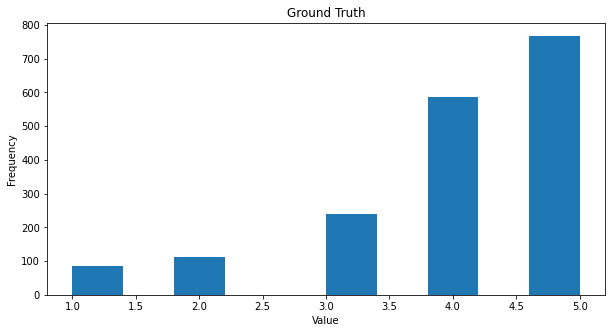

In [144]:
#what is the distrubution in ground truth scores like?
getHistogram(finaldf,'ratingScore', 'Ground Truth')

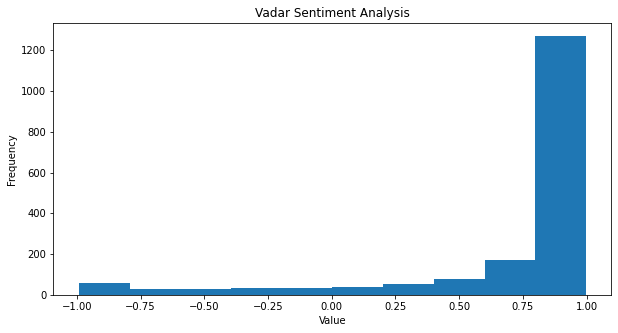

In [145]:
# what is the distrubtuion in vader scores like?
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

**For histogram of ground truth scores: Frequency is increase as ground truth scores is higher. For histogram of vader scores: Majority proportion of vader scores are in the range of 0.8-1.0, which is different from distribution of ground truth scores.**

**(ii).**

Text(0.5, 0, 'hotel name')

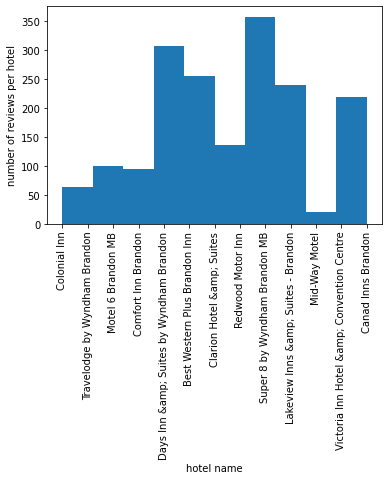

In [146]:
plt.hist(df.hotelName)
plt.xticks(rotation=90)
plt.ylabel('number of reviews per hotel')
plt.xlabel('hotel name')

In [147]:
df_rating_sort

,average_ground_truth_rating,average_Vader_sentiment
hotelName,,
Super 8 by Wyndham Brandon MB,4.324930,0.762683
Best Western Plus Brandon Inn,4.259843,0.795885
Days Inn &amp; Suites by Wyndham Brandon,4.254072,0.666563
Motel 6 Brandon MB,4.150000,0.763756
Lakeview Inns &amp; Suites - Brandon,4.129707,0.723138
Victoria Inn Hotel &amp; Convention Centre,3.944000,0.757114
Comfort Inn Brandon,3.800000,0.754842
Clarion Hotel &amp; Suites,3.500000,0.591727
Mid-Way Motel,3.400000,0.808930


**I found that top 3 highest ground truth rating hotels(Super 8 by Wyndham Brandon MB, Best Western Plus Brandon Inn, Days Inn &amp; Suites by Wyndham Brandon) also got the top 3 highest number of reviews, which is reasonable since people are willing to go to high rated hotels, and more reviews would be posted if more people spent money on those hotels. Colonial Inn got the second lowest number of reviews and it actually got the lowest ground truth rating, which is also reasonable, less people are willing to go to low rated hotels and fewer number of reviews would be posted online.**

**(b). Boxplots (i)**

In [148]:
five_hotels_gt = df_rating_sort.reset_index().hotelName[:5].tolist()

In [149]:
top5_hotels_gt = df[df.hotelName.isin(five_hotels_gt)]

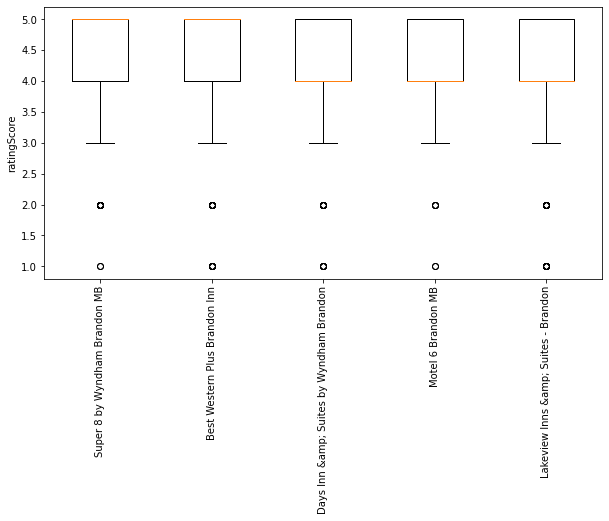

In [150]:
hotel_list = []
for hotel in five_hotels_gt:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['ratingScore']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels_gt,rotation=90)
plt.ylabel('ratingScore')
plt.show()

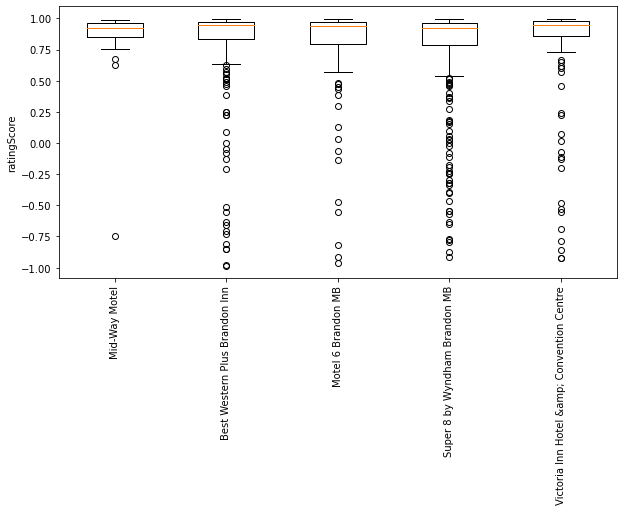

In [151]:
five_hotels_vader = df_vader_sort.reset_index().hotelName[:5].tolist()
top5_hotels_vader = df[df.hotelName.isin(five_hotels_vader)]
hotel_list = []
for hotel in five_hotels_vader:
  _hotel = finaldf.loc[finaldf['hotelName'] == hotel]['vader']
  hotel_list.append(_hotel)


# multiple box plots on one figure
plt.figure(figsize=(10,5))
plt.boxplot(hotel_list)
plt.xticks(np.arange(1,6), five_hotels_vader,rotation=90)
plt.ylabel('ratingScore')
plt.show()

**(ii).**

In [152]:
top5_hotels_gt.groupby('hotelName')['ratingScore'].mean()

hotelName
Best Western Plus Brandon Inn               4.259843
Days Inn &amp; Suites by Wyndham Brandon    4.254072
Lakeview Inns &amp; Suites - Brandon        4.129707
Motel 6 Brandon MB                          4.150000
Super 8 by Wyndham Brandon MB               4.324930
Name: ratingScore, dtype: float64

In [153]:
top5_hotels_gt.groupby('hotelName')['ratingScore'].var()

hotelName
Best Western Plus Brandon Inn               1.038934
Days Inn &amp; Suites by Wyndham Brandon    0.824126
Lakeview Inns &amp; Suites - Brandon        1.222601
Motel 6 Brandon MB                          0.957071
Super 8 by Wyndham Brandon MB               0.759292
Name: ratingScore, dtype: float64

In [154]:
top5_hotels_vader.groupby('hotelName')['vader'].mean()

hotelName
Best Western Plus Brandon Inn                 0.795885
Mid-Way Motel                                 0.808930
Motel 6 Brandon MB                            0.763756
Super 8 by Wyndham Brandon MB                 0.762683
Victoria Inn Hotel &amp; Convention Centre    0.757114
Name: vader, dtype: float64

In [155]:
top5_hotels_vader.groupby('hotelName')['vader'].var()

hotelName
Best Western Plus Brandon Inn                 0.150781
Mid-Way Motel                                 0.143731
Motel 6 Brandon MB                            0.176139
Super 8 by Wyndham Brandon MB                 0.148831
Victoria Inn Hotel &amp; Convention Centre    0.212341
Name: vader, dtype: float64

**(iii)**

**I think boxplots are more informative in vader rating. Since boxplots visualize the median, 25 percentile, 75 percentile, min, max and outliers. Those are clearly visualized in vader boxplot, and we can see that median value is quite close to mean value, and also variance can also be approximately known by median, 25 percentile, 75 percentile, min, max. Besides that, boxplot provides the distribution of vader scores in boxplot while mean and variance cannot provide. But for ground truth rating, left 2 boxplots are almost the same, and also the right 3 boxplots are almost the same. I cannot figure out the difference of similar boxplots. But if we look at mean and variance, we can easily find the difference.**

**(c). Scatterplots and heatmaps (i)**

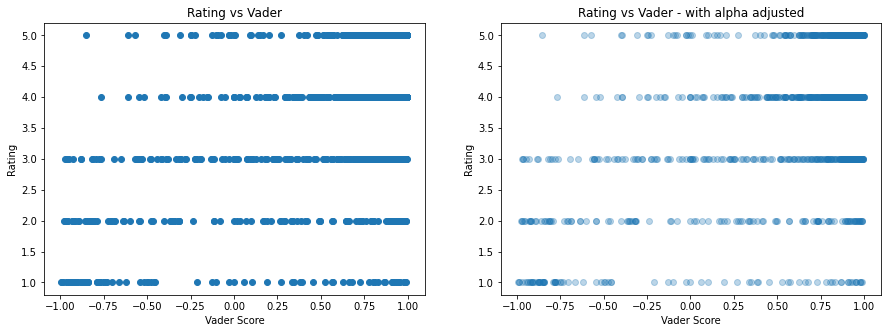

In [156]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(vader_scores, rating_scores,"o")
ax[1].plot(vader_scores, rating_scores,"o", alpha=0.3)

ax[0].set_title('Rating vs Vader')
ax[1].set_title('Rating vs Vader - with alpha adjusted')

for _ax in ax:
  _ax.set_ylabel('Rating')
  _ax.set_xlabel('Vader Score')

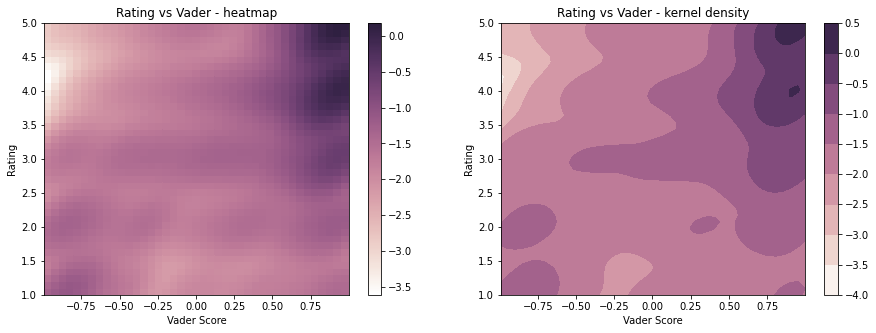

In [157]:
k = gaussian_kde(np.vstack([vader_scores, rating_scores]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(rating_scores.min(), rating_scores.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(rating_scores.min(), rating_scores.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('Rating vs Vader - heatmap')
ax2.set_title('Rating vs Vader - kernel density');

**Scatterplot indicate that for low ground truth rating score(1-2), majority of vader score are negative(approach -1). For high ground truth rating score(4-5), majority of vader score are positive(approach 1). Heatmap indicate that high ground truth rating and high positive correlation to high vader score. And rest of them does not have high correlation.**

**(ii).**

Text(0.5, 0, 'Vader')

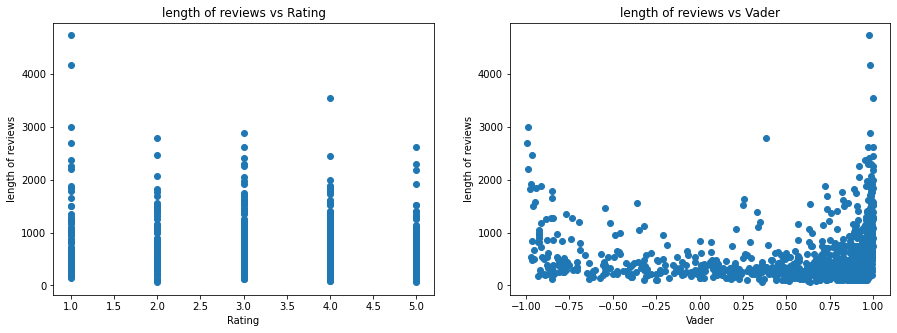

In [158]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
len_reviews = np.array([len(i) for i in finaldf.reviewCol])
rating_scores = finaldf['ratingScore'].values
vader_scores = finaldf['vader'].values
ax[0].plot(rating_scores, len_reviews, "o")
ax[1].plot(vader_scores, len_reviews, "o")

ax[0].set_title('length of reviews vs Rating')
ax[1].set_title('length of reviews vs Vader')

for _ax in ax:
  _ax.set_ylabel('length of reviews')

ax[0].set_xlabel('Rating')
ax[1].set_xlabel('Vader')

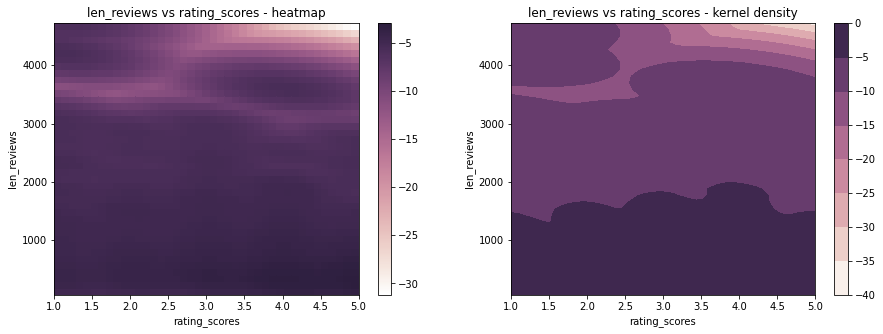

In [159]:
k = gaussian_kde(np.vstack([rating_scores, len_reviews]))
xi, yi = np.mgrid[rating_scores.min():rating_scores.max():rating_scores.size**0.5*1j,len_reviews.min():len_reviews.max():len_reviews.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(rating_scores.min(), rating_scores.max())
ax1.set_ylim(len_reviews.min(), len_reviews.max())
ax2.set_xlim(rating_scores.min(), rating_scores.max())
ax2.set_ylim(len_reviews.min(), len_reviews.max())

ax1.set_xlabel('rating_scores')
ax1.set_ylabel('len_reviews')

ax2.set_xlabel('rating_scores')
ax2.set_ylabel('len_reviews')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('len_reviews vs rating_scores - heatmap')
ax2.set_title('len_reviews vs rating_scores - kernel density');

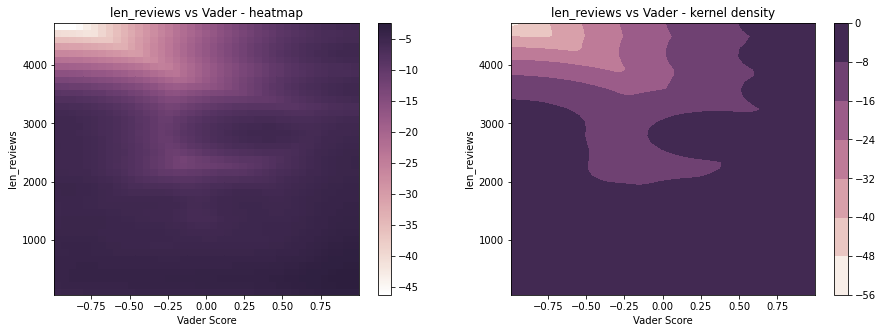

In [160]:
k = gaussian_kde(np.vstack([vader_scores, len_reviews]))
xi, yi = np.mgrid[vader_scores.min():vader_scores.max():vader_scores.size**0.5*1j,len_reviews.min():len_reviews.max():len_reviews.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))


b1 = ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
b2 = ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(vader_scores.min(), vader_scores.max())
ax1.set_ylim(len_reviews.min(), len_reviews.max())
ax2.set_xlim(vader_scores.min(), vader_scores.max())
ax2.set_ylim(len_reviews.min(), len_reviews.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('len_reviews')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('len_reviews')

fig.colorbar(b1, ax=ax1)
fig.colorbar(b2, ax=ax2)

ax1.set_title('len_reviews vs Vader - heatmap')
ax2.set_title('len_reviews vs Vader - kernel density');

**From scatterplots, we can only find that length of reviews are usually below 3000. And also, length of reviews are largest for the highest vader score, length of reveiws are also large for the lowest vader score. length of reveiws are almost under 1000 for vader scores in the range of [-0.75,0.75].**


**(iii).**

In [161]:
finaldf_hotel = finaldf.groupby('hotelName')[['ratingScore', 'vader']].mean()

In [162]:
finaldf_hotel.columns = ['averageRating', 'averageVader']
finaldf_hotel

,averageRating,averageVader
hotelName,,
Best Western Plus Brandon Inn,4.259843,0.795885
Canad Inns Brandon,3.382979,0.640087
Clarion Hotel &amp; Suites,3.500000,0.591727
Colonial Inn,2.617647,0.450179
Comfort Inn Brandon,3.800000,0.754842
Days Inn &amp; Suites by Wyndham Brandon,4.254072,0.666563
Lakeview Inns &amp; Suites - Brandon,4.129707,0.723138
Mid-Way Motel,3.400000,0.808930
Motel 6 Brandon MB,4.150000,0.763756


In [163]:
reviews_hotel = np.array([finaldf[finaldf.hotelName==i].shape[0] for i in finaldf_hotel.index])

Text(0.5, 0, 'averageVader')

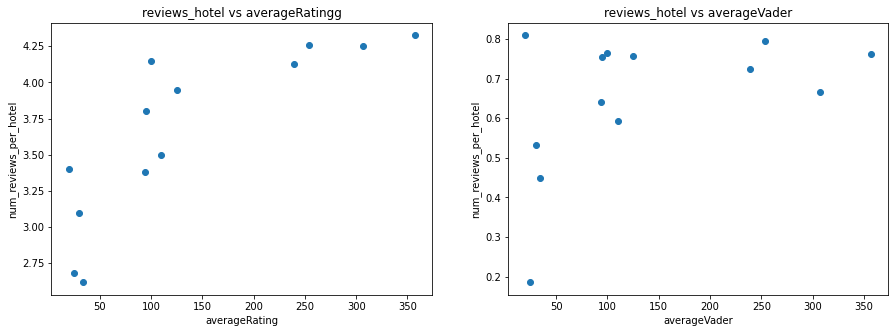

In [164]:
fig, ax = plt.subplots(1,2,figsize=(15,5),sharex=False,sharey=False)
avg_rating_scores = finaldf_hotel['averageRating'].values
avg_vader_scores = finaldf_hotel['averageVader'].values
ax[0].plot(reviews_hotel, avg_rating_scores,"o")
ax[1].plot(reviews_hotel, avg_vader_scores,"o")

ax[0].set_title('reviews_hotel vs averageRatingg')
ax[1].set_title('reviews_hotel vs averageVader')

for _ax in ax:
  _ax.set_ylabel('num_reviews_per_hotel')

ax[0].set_xlabel('averageRating')
ax[1].set_xlabel('averageVader')

**There is no strong relationship between number of reviews per hotel and average ground truth rating. Also there is no strong relationship between number of reviews per hotel and average vader score. But we can still find that num of reviews per hotel is almost postive to average ground truth rating, which is reasonable, people should be more willing to spent money on high rated hotels, and the more people come, the more number of reviews would be posted online. But number reviews per hotel and average vader scores seems no clear trend.**

**(d) Location-based patterns**

In [165]:
#Extract a list of hotels
# this of course may need to be filtered 
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Colonial Inn', 'Travelodge by Wyndham Brandon',
       'Motel 6 Brandon MB', 'Comfort Inn Brandon',
       'Days Inn &amp; Suites by Wyndham Brandon',
       'Best Western Plus Brandon Inn', 'Clarion Hotel &amp; Suites',
       'Redwood Motor Inn', 'Super 8 by Wyndham Brandon MB',
       'Lakeview Inns &amp; Suites - Brandon', 'Mid-Way Motel',
       'Victoria Inn Hotel &amp; Convention Centre', 'Canad Inns Brandon'],
      dtype=object)

In [166]:
def avg_rating_per_hotel(df):
  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','ratingScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageRatingScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageRatingScore':'mean','n_reviews':'count'})
  return tempDf

In [167]:
avg_rating_df = avg_rating_per_hotel(finaldf)
avg_rating_df.head()

,AverageVader,AverageRatingScore,n_reviews
hotelName,,,
Best Western Plus Brandon Inn,0.795885,4.259843,254
Canad Inns Brandon,0.640087,3.382979,94
Clarion Hotel &amp; Suites,0.591727,3.500000,110
Colonial Inn,0.450179,2.617647,34
Comfort Inn Brandon,0.754842,3.800000,95


In [168]:
def make_address(row):
  # individual columns need to be combined
  return row['streetAddress']+", "+row['City']+", "+row['Province']


# Need the location for each hotel in a format the tool can handle

geo_rating_df = avg_rating_df\
                         .join(df.groupby('hotelName')\
                         .agg({'streetAddress':'max','City':'max','Province':'max','postalCode':'max'}))
geo_rating_df['formed_address'] = geo_rating_df.apply(make_address , axis=1)
geo_rating_df.tail()

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address
hotelName,,,,,,,,
Motel 6 Brandon MB,0.763756,4.15000,100,815 Middleton Ave,Brandon,Manitoba,R7C 1A8,"815 Middleton Ave, Brandon, Manitoba"
Redwood Motor Inn,0.185456,2.68000,25,345 18th St,Brandon,Manitoba,R7A 5A8,"345 18th St, Brandon, Manitoba"
Super 8 by Wyndham Brandon MB,0.762683,4.32493,357,1570 Highland Ave,Brandon,Manitoba,R7C 1A7,"1570 Highland Ave, Brandon, Manitoba"
Travelodge by Wyndham Brandon,0.531937,3.10000,30,210 18th St N,Brandon,Manitoba,R7A 6P3,"210 18th St N, Brandon, Manitoba"
Victoria Inn Hotel &amp; Convention Centre,0.757114,3.94400,125,3550 Victoria Ave,Brandon,Manitoba,R7B 2R4,"3550 Victoria Ave, Brandon, Manitoba"


In [169]:
# 0 - need to give the tool a generic name.
locator = Nominatim(user_agent='myGeocoder')
# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2 - form the location string
geo_rating_df['location'] = geo_rating_df['formed_address'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
geo_rating_df['point'] = geo_rating_df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
geo_rating_df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(geo_rating_df['point'].tolist(), index=geo_rating_df.index)

geo_rating_df

,AverageVader,AverageRatingScore,n_reviews,streetAddress,City,Province,postalCode,formed_address,location,point,latitude,longitude,altitude
hotelName,,,,,,,,,,,,,
Best Western Plus Brandon Inn,0.795885,4.259843,254,205 Middleton Ave,Brandon,Manitoba,R7C 1A8,"205 Middleton Ave, Brandon, Manitoba","(Middleton Avenue, Highland Park, Brandon, Man...","(49.8883183, -99.9392662, 0.0)",49.888318,-99.939266,0.0
Canad Inns Brandon,0.640087,3.382979,94,1125 18th St Keystone Centre,Brandon,Manitoba,R7A 7C5,"1125 18th St Keystone Centre, Brandon, Manitoba",None,None,NaN,NaN,NaN
Clarion Hotel &amp; Suites,0.591727,3.500000,110,3130 Victoria Ave,Brandon,Manitoba,R7B 3Y3,"3130 Victoria Ave, Brandon, Manitoba","(Victoria Avenue, Meadows, Brandon, Manitoba, ...","(49.842194, -99.9618249, 0.0)",49.842194,-99.961825,0.0
Colonial Inn,0.450179,2.617647,34,1944 Queens Ave,Brandon,Manitoba,R7B 0T1,"1944 Queens Ave, Brandon, Manitoba","(Queens Avenue, Meadows, Brandon, Manitoba, R7...","(49.8293677, -99.9618347, 0.0)",49.829368,-99.961835,0.0
Comfort Inn Brandon,0.754842,3.800000,95,925 Middleton Ave,Brandon,Manitoba,R7C 1A8,"925 Middleton Ave, Brandon, Manitoba","(Middleton Avenue, Highland Park, Brandon, Man...","(49.8883183, -99.9392662, 0.0)",49.888318,-99.939266,0.0
Days Inn &amp; Suites by Wyndham Brandon,0.666563,4.254072,307,2130 Currie Blvd,Brandon,Manitoba,R7B 4E7,"2130 Currie Blvd, Brandon, Manitoba","(Currie Boulevard, Richmond Park, Brandon, Man...","(49.818245, -99.96249, 0.0)",49.818245,-99.962490,0.0
Lakeview Inns &amp; Suites - Brandon,0.723138,4.129707,239,1880 18th St N,Brandon,Manitoba,R7C 1A5,"1880 18th St N, Brandon, Manitoba","(18th Street North, Corral Centre, Hamilton He...","(49.8688608, -99.9617512, 0.0)",49.868861,-99.961751,0.0
Mid-Way Motel,0.808930,3.400000,20,1860 1st St N,Brandon,Manitoba,R7C 1A9,"1860 1st St N, Brandon, Manitoba","(1st Street North, Highland Park, Brandon, Man...","(49.886808, -99.938984, 0.0)",49.886808,-99.938984,0.0
Motel 6 Brandon MB,0.763756,4.150000,100,815 Middleton Ave,Brandon,Manitoba,R7C 1A8,"815 Middleton Ave, Brandon, Manitoba","(Middleton Avenue, Highland Park, Brandon, Man...","(49.8883183, -99.9392662, 0.0)",49.888318,-99.939266,0.0


**Mannually add longitude and latitude to Canad Inns Brandon. And also some hotels got the same longitude and latitude since the point accuracy are not precise enough, I will mannually replace them with more precise longtitude and altitude to make sure that their visualization(red circles) would not be overlapped.**

In [170]:
geo_rating_df.loc['Canad Inns Brandon', 'location'] = '(St Keystone Centre, Brandon, Manitoba, R7A 7C5)'
geo_rating_df.loc['Canad Inns Brandon', 'point'] = '(49.832716604687825, -99.96119177327539, 0.0)'
geo_rating_df.loc['Canad Inns Brandon', 'latitude'] = '49.832716604687825'
geo_rating_df.loc['Canad Inns Brandon', 'longitude'] = '-99.96119177327539'
geo_rating_df.loc['Canad Inns Brandon', 'altitude'] = '0'
geo_rating_df.loc['Best Western Plus Brandon Inn', 'point'] = '(49.88780475329312, -99.94136172909472)'
geo_rating_df.loc['Best Western Plus Brandon Inn', 'latitude'] = '49.88780475329312'
geo_rating_df.loc['Best Western Plus Brandon Inn', 'longitude'] = '-99.94136172909472'
geo_rating_df.loc['Comfort Inn Brandon', 'point'] = '(49.8878293532155, -99.94935357327309)'
geo_rating_df.loc['Comfort Inn Brandon', 'latitude'] = '49.8878293532155'
geo_rating_df.loc['Comfort Inn Brandon', 'longitude'] = '-99.94935357327309'
geo_rating_df.loc['Motel 6 Brandon MB', 'point'] = '(49.88779031594151, -99.94832135793041)'
geo_rating_df.loc['Motel 6 Brandon MB', 'latitude'] = '49.88779031594151'
geo_rating_df.loc['Motel 6 Brandon MB', 'longitude'] = '-99.94832135793041'
geo_rating_df.loc['Lakeview Inns &amp; Suites - Brandon', 'point']  = '(49.884881062503794, -99.96346173094453)'
geo_rating_df.loc['Lakeview Inns &amp; Suites - Brandon', 'latitude'] = '49.884881062503794'
geo_rating_df.loc['Lakeview Inns &amp; Suites - Brandon', 'longitude'] = '-99.96346173094453'
geo_rating_df.loc['Travelodge by Wyndham Brandon', 'point'] = '(49.854629040571936, -99.96284217327448)'
geo_rating_df.loc['Travelodge by Wyndham Brandon', 'latitude'] = '49.854629040571936'
geo_rating_df.loc['Travelodge by Wyndham Brandon', 'longitude'] = '-99.96284217327448'
geo_rating_df.loc['Clarion Hotel &amp; Suites', 'point'] = '(49.955282107796954, -99.97869413772848)'
geo_rating_df.loc['Clarion Hotel &amp; Suites', 'latitude'] = '49.955282107796954'
geo_rating_df.loc['Clarion Hotel &amp; Suites', 'longitude'] = '-99.97869413772848'
geo_rating_df.loc['Victoria Inn Hotel &amp; Convention Centre', 'point'] = '(49.916020613946756, -99.97877144831268)'
geo_rating_df.loc['Victoria Inn Hotel &amp; Convention Centre', 'latitude'] = '49.916020613946756'
geo_rating_df.loc['Victoria Inn Hotel &amp; Convention Centre', 'longitude'] = '-99.97877144831268'

In [171]:
geo_rating_df[['latitude', 'longitude', 'altitude']] = geo_rating_df[['latitude', 'longitude', 'altitude']].applymap(float)
geo_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, Best Western Plus Brandon Inn to Victoria Inn Hotel &amp; Convention Centre
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AverageVader        13 non-null     float64
 1   AverageRatingScore  13 non-null     float64
 2   n_reviews           13 non-null     int64  
 3   streetAddress       13 non-null     object 
 4   City                13 non-null     object 
 5   Province            13 non-null     object 
 6   postalCode          13 non-null     object 
 7   formed_address      13 non-null     object 
 8   location            13 non-null     object 
 9   point               13 non-null     object 
 10  latitude            13 non-null     float64
 11  longitude           13 non-null     float64
 12  altitude            13 non-null     float64
dtypes: float64(5), int64(1), object(7)
memory usage: 2.0+ KB


In [172]:
map1 = folium.Map(
    location=[49.888318,-99.939266], # <- this will need to be set based on your own hotels
    tiles='cartodbpositron',
    zoom_start=12,
)

geo_rating_df.dropna().apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]], color='#d7191c', popup=folium.Popup(str(row['AverageRatingScore']))).add_to(map1), axis=1)


map1


**There are visible relationship between reviews and location. In MEADOWS, three hotels got the 3 out of top 4 lowest average ground truth rating and only of 2 are the lowest ratings. WOODLANDS has only 1 hotel 'Best Western Plus Brandon Inn', but it got the second highest average ground truth rating. In Trans Canada Highway, 5 out of 6 hotels got average ground truth rating over 3.8 and 4 of them over 4. And for other regions, they have both high rated and low rated ground truth rating. Therefore, I would recommend staying WOODLANDS and Trans Canada Highway. I would recommend avoiding MEADOWS.**

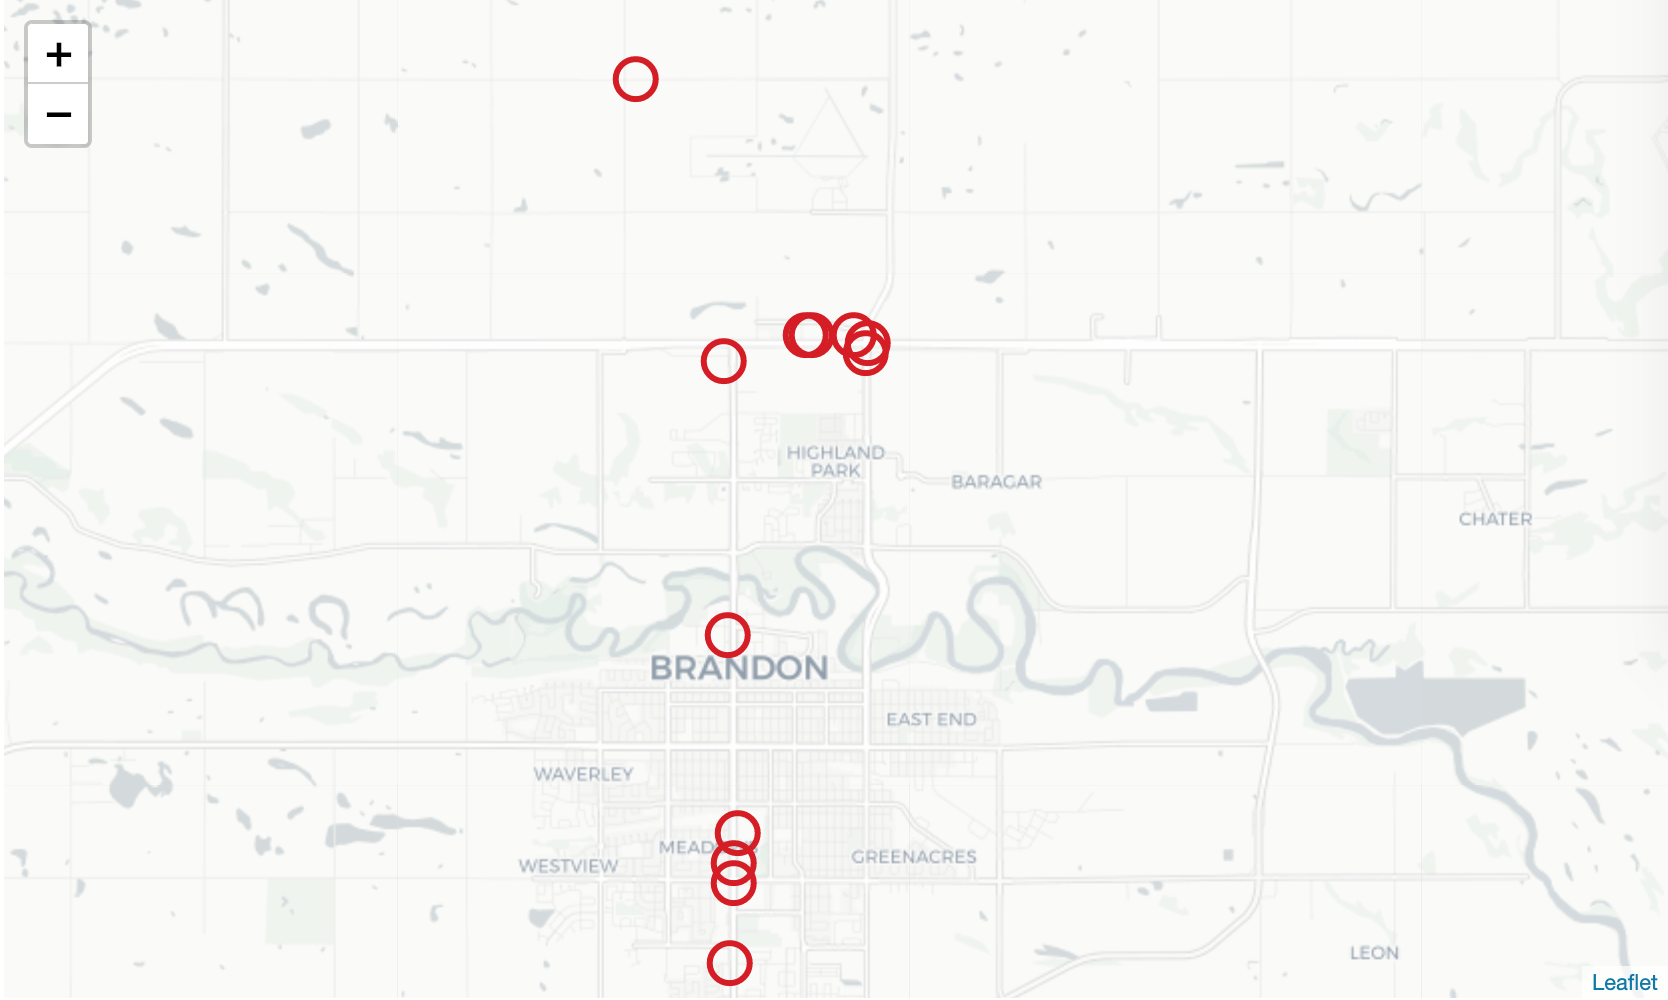

In [173]:
## folium graphs are best saved as screenshot images to be reloaded into the notebook

from IPython.display import Image
Image('Brandon_demo.png')

**(e) Temporal analysis**

In [174]:
avg_rating_df.sort_values('AverageRatingScore', ascending=False)

,AverageVader,AverageRatingScore,n_reviews
hotelName,,,
Super 8 by Wyndham Brandon MB,0.762683,4.324930,357
Best Western Plus Brandon Inn,0.795885,4.259843,254
Days Inn &amp; Suites by Wyndham Brandon,0.666563,4.254072,307
Motel 6 Brandon MB,0.763756,4.150000,100
Lakeview Inns &amp; Suites - Brandon,0.723138,4.129707,239
Victoria Inn Hotel &amp; Convention Centre,0.757114,3.944000,125
Comfort Inn Brandon,0.754842,3.800000,95
Clarion Hotel &amp; Suites,0.591727,3.500000,110
Mid-Way Motel,0.808930,3.400000,20


1.   **2 highly rated hotels: Super 8 by Wyndham Brandon MB(357 reviews/rating score:4.32493), Best Western Plus Brandon Inn(254 reviews/rating score:4.259843).**
2.   **2 lowly rated hotels: Colonial Inn(34 reviews/rating score:2.617647), Redwood Motor Inn(25 reviews/rating score:2.68).**
3.   **2 mediocre rated hotels: Lakeview Inns &amp; Suites - Brandon(239 reviews/rating score:4.129707), Victoria Inn Hotel &amp; Convention Centre	(125 reviews/rating score:3.944000)**



In [175]:
# 2 groups with any of them contain 1 high rated, 1 mediocre rated, and 1 low rated hotel.
hotels_A = ['Super 8 by Wyndham Brandon MB', 'Colonial Inn', 'Lakeview Inns &amp; Suites - Brandon']
hotels_B = ['Best Western Plus Brandon Inn', 'Redwood Motor Inn', 'Victoria Inn Hotel &amp; Convention Centre']

In [176]:
df[df.date_stamp=='4 weeks ago']

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode,reviewCol,vader
1366,data/ca/154951/183497/773454370.html,Lakeview Inns &amp; Suites - Brandon,"""I booked this hotel on Booking.com and was up...",1,negative,4 weeks ago,1880 18th St N,Brandon,Manitoba,R7C 1A5,"""I booked this hotel on Booking.com and was up...",-0.101


In [177]:
df[df.date_stamp=='3 weeks ago']

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode,reviewCol,vader
136,data/ca/154951/2011106/774766289.html,Motel 6 Brandon MB,"""We stayed for the night driving through from ...",5,positive,3 weeks ago,815 Middleton Ave,Brandon,Manitoba,R7C 1A8,"""We stayed for the night driving through from ...",0.9748
1413,data/ca/154951/183497/774414088.html,Lakeview Inns &amp; Suites - Brandon,"""Clean, cozy, comfortable. Great check in a...",5,positive,3 weeks ago,1880 18th St N,Brandon,Manitoba,R7C 1A5,"""Clean, cozy, comfortable. Great check in a...",0.9729


**There are 3 date_stamps that are not formal format of date_stamp, which cannot be successfully convert to datetime format. So I remove this rows.**

In [178]:
df.drop(index=1366,inplace=True)
df.drop(index=136,inplace=True)
df.drop(index=1413,inplace=True)

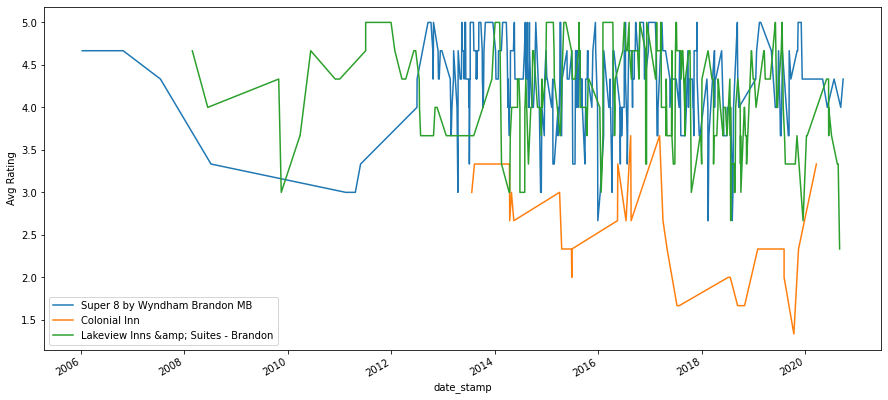

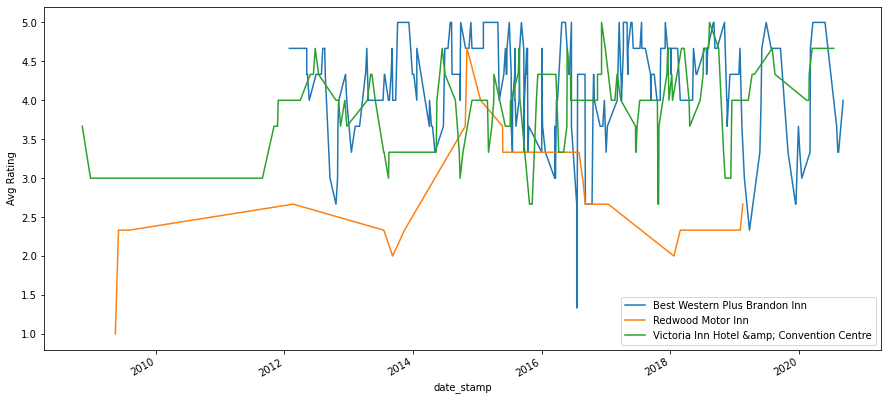

In [179]:
# It can be useful to see when reviews were being made and how the ratings changed using a running mean
fig, ax = plt.subplots(1, 1, figsize=(15,7),
                       sharex=True,
                       )

for hotel in hotels_A: 
  _df = df[df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  # _df['count'] = 1
  # _df['count'].cumsum().plot(ax=ax[0],label=selected_hotels[hotel], marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax,label=hotel)

# ax[1].set_ylabel('Avg Rating')
ax.set_ylabel('Avg Rating')
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(15,7),
                       sharex=True,
                       )

for hotel in hotels_B: 
  _df = df[df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  # _df['count'] = 1
  # _df['count'].cumsum().plot(ax=ax[0],label=selected_hotels[hotel], marker='o')
  _df['ratingScore'].rolling(3).mean().plot(ax=ax,label=hotel)

# ax[1].set_ylabel('Avg Rating')
ax.set_ylabel('Avg Rating')
plt.legend()

**High rated, mediocre rated hotels' average rating fluctuated over the date stamp. But high rated hotels'(Super 8 by Wyndham Brandon MB, Best Western Plus Brandon Inn) average ratings fluctuated on high rating range, and mediocre rated hotels'(Lakeview Inns & Suites - Brandon, Victoria Inn Hotel & Convention Centre) average ratings fluctuated on mediocre rating range. And low rated hotels' have relative smaller fluctuations on avergae ratings over date stamp.**

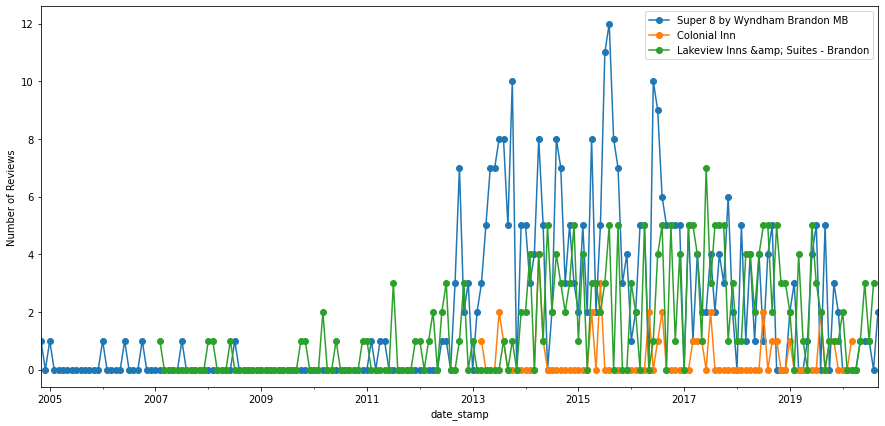

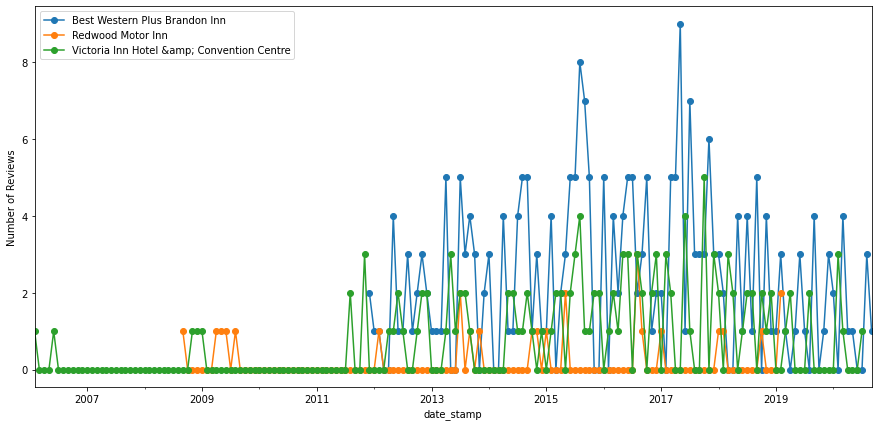

In [180]:
# It can be useful to see when reviews were being made and how the ratings changed
fig, ax = plt.subplots(1, 1, figsize=(15,7),
                       sharex=True,
                      )

for hotel in hotels_A:
  _df = df[df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  # _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax,label=hotel, marker='o')
  # _df_monthly['ratingScore'].plot(ax=ax[1],label=selected_hotels[hotel])

# ax[1].set_ylabel('Avg Rating')
ax.set_ylabel('Number of Reviews')
plt.legend()

fig, ax = plt.subplots(1, 1, figsize=(15,7),
                       sharex=True,
                       )

for hotel in hotels_B: 
  _df = df[df['hotelName']==hotel].set_index('date_stamp')
  _df.index = pd.to_datetime(_df.index)
  _df = _df.sort_index()
  _df['count'] = 1
  _df_monthly = _df.groupby(pd.Grouper(freq='M')).agg({'count':'sum','ratingScore':'mean'})
  # _df_monthly['ratingScore'] = _df_monthly['ratingScore'].fillna(method='ffill') # hold the last rating constant in months with no reviews
  _df_monthly['count'].plot(ax=ax,label=hotel, marker='o')
  # _df_monthly['ratingScore'].plot(ax=ax[1],label=selected_hotels[hotel])

# ax[1].set_ylabel('Avg Rating')
ax.set_ylabel('Number of Reviews')
plt.legend()

**Fixed period: by month. number of reviews of all high rated, mediocre rated, and low rated hotels fluctuated. But number of reviews of high rated hotels fluctuated in high number of range, this range is higher than the range of number of reviews of mediocre rated hotels. And also, number of reviews of mediocre rated hotels fluctuated in intermediate number of range, this range is higher than the range of number of reviews of low rated hotels. In total, high rated hotels always has higher number of reviews than mediocre rated hotels, and mediocre rated hotels always has higher number of reviews than low rated hotels. These trends are reasonable, since all people can see reviews online, and people are more willings to go to high rated hotels. The more people come, the more number of reviews would be posted online.**